# Sentiment Analysis

Now, we have our cleaned dataset. We can start do our sentiment analysis on the comments about ```VOO``` from Subreddit ```r/ETFs```.

## Import Libraries

In [495]:
import pandas as pd

import torch

## Import the datasets

In [496]:
df = pd.read_csv('../datasets/cleaned_cmts_voo.csv')
df.head()

,author,id,date,permalink,body,score,subreddit
0,investing_me,kwsc2e7,2024-03-27,/r/ETFs/comments/1boyqg6/375qqq125tqqq375voo12...,Just buy VOO at this point,6,ETFs
1,iamfredrick,kwv4b7y,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwv4...,Voo & schg have 53% overlap. Past results don’...,3,ETFs
2,Fun_Grapefruit_3416,kwvj6cq,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvj...,Schd + Schg makes up the majority of voo. Just...,2,ETFs
3,rem14,kwvnzn8,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvn...,13% overlap with VOO and less than 1% overlap ...,2,ETFs
4,DITPiranha,kx0qfv5,2024-03-28,/r/ETFs/comments/1bq2hk5/voo_vgt_vti/kx0qfv5/,"30% VOO, 30% QQQ, 10% VYM, 10% BND, 10% Mixed ...",1,ETFs


## Using Transformer Model in Sentiment Analysis

### Example
An example to show the model works.

In [497]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [498]:
sentence_pos = "Stock price of VOO will go higher"
sentence_neg = "Never ever buy VOO"

In [499]:
classifier(sentence_pos), classifier(sentence_neg)

([{'label': 'POSITIVE', 'score': 0.5957298278808594}],
 [{'label': 'NEGATIVE', 'score': 0.9967347979545593}])

In [500]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [501]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [502]:
inputs_pos, inputs_neg = tokenizer(sentence_pos), tokenizer(sentence_neg)

In [503]:
inputs_pos, inputs_neg

({'input_ids': [101, 4518, 3976, 1997, 29536, 2080, 2097, 2175, 3020, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2196, 2412, 4965, 29536, 2080, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]})

In [504]:
tokenizer.convert_ids_to_tokens([29536, 2080])

['vo', '##o']

In [505]:
pt_batch = tokenizer(
    [sentence_pos, sentence_neg], 
    padding=True, 
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

In [506]:
pt_batch

{'input_ids': tensor([[  101,  4518,  3976,  1997, 29536,  2080,  2097,  2175,  3020,   102],
        [  101,  2196,  2412,  4965, 29536,  2080,   102,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

In [507]:
pt_outputs = pt_model(**pt_batch)

pt_outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1119,  0.2758],
        [ 3.1458, -2.5754]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [508]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_label_and_score(output):
    # Apply softmax to output logits
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)

    # Get the predicted label (0 or 1) based on the highest probability
    label = torch.argmax(probabilities, dim=-1).item()

    # Get the probability score for the predicted label
    score = probabilities[0][label].item()

    return label, score

results = []

for comment in df['body']:
    pt_batch = tokenizer(
        str(comment), 
        padding=True, 
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    pt_outputs = pt_model(**pt_batch)
    label, score = get_label_and_score(pt_outputs)
    results.append((label, score))

labels, scores = zip(*results)
df['sentiment_label'] = labels
df['sentiment_score'] = scores


In [509]:
df.head()

,author,id,date,permalink,body,score,subreddit,sentiment_label,sentiment_score
0,investing_me,kwsc2e7,2024-03-27,/r/ETFs/comments/1boyqg6/375qqq125tqqq375voo12...,Just buy VOO at this point,6,ETFs,1,0.513832
1,iamfredrick,kwv4b7y,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwv4...,Voo & schg have 53% overlap. Past results don’...,3,ETFs,1,0.990680
2,Fun_Grapefruit_3416,kwvj6cq,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvj...,Schd + Schg makes up the majority of voo. Just...,2,ETFs,0,0.997663
3,rem14,kwvnzn8,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvn...,13% overlap with VOO and less than 1% overlap ...,2,ETFs,0,0.995360
4,DITPiranha,kx0qfv5,2024-03-28,/r/ETFs/comments/1bq2hk5/voo_vgt_vti/kx0qfv5/,"30% VOO, 30% QQQ, 10% VYM, 10% BND, 10% Mixed ...",1,ETFs,0,0.992688


In [510]:
sentiment_df = df[['date', 'body', 'sentiment_label', 'sentiment_score']]

sentiment_df.head()

,date,body,sentiment_label,sentiment_score
0,2024-03-27,Just buy VOO at this point,1,0.513832
1,2024-03-27,Voo & schg have 53% overlap. Past results don’...,1,0.990680
2,2024-03-27,Schd + Schg makes up the majority of voo. Just...,0,0.997663
3,2024-03-27,13% overlap with VOO and less than 1% overlap ...,0,0.995360
4,2024-03-28,"30% VOO, 30% QQQ, 10% VYM, 10% BND, 10% Mixed ...",0,0.992688


In [511]:
sentiment_df.isnull().sum()

date               0
body               0
sentiment_label    0
sentiment_score    0
dtype: int64

## Visualizing the Data

### 1. Time Series of Sentiment Counts
- **What it shows**: A bar chart displaying the comparison of the count of positive and negative comments over time.
- **Interpretation**: 
  - The height of the bars represents the count of sentiments (positive or negative) on each date.
  - A higher bar for positive sentiments on a specific date indicates more positive comments, and vice versa for negative sentiments.
  - The comparison between the heights of positive and negative bars on each date gives a visual representation of the predominant sentiment on that day.
- **Insights**: 
  - This visualization allows for the identification of dates with a significant imbalance between positive and negative sentiments, which can be indicative of specific events or changes in public perception.
  - Patterns or trends, such as periods with consistently more positive or negative sentiments, can be easily spotted and correlated with external events or news.
  - Sudden changes in the balance between positive and negative sentiment bars can signal shifts in public mood or reaction to specific occurrences.

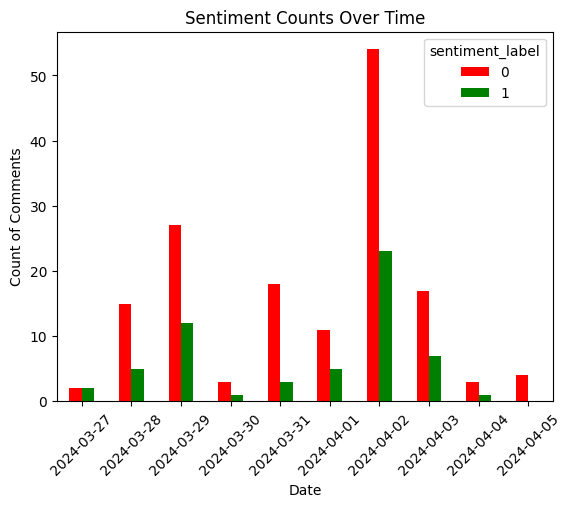

In [512]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'date': sentiment_df['date'],
    'sentiment_label': sentiment_df['sentiment_label'],
    'body': sentiment_df['body']
}

visualization_df = pd.DataFrame(data)

# Group by 'date' and 'sentiment_label', and count comments
grouped = visualization_df.groupby(['date', 'sentiment_label']).size().reset_index(name='count')

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='count').fillna(0)

# Plotting
pivot_df.plot(kind='bar', color=['red', 'green'])
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.title('Sentiment Counts Over Time')
plt.xticks(rotation=45)
plt.show()

### Heatmap for Sentiment Analysis
#### Heatmap for Sentiment Count
- **What it shows**: Displays the number of positive and negative comments for each date.
- **Interpretation**: 
  - Each cell represents the count of either positive or negative comments on a specific date.
  - The color intensity reflects the volume of comments - darker colors indicate a higher number of comments.
- **Insights**: 
  - Enables identification of dates with unusually high or low activity in terms of comment volume.
  - Can be correlated with specific events or news to understand what drives increased discussion and sentiment expression.

#### Heatmap for Average Sentiment Intensity
- **What it shows**: Represents the average sentiment score for positive and negative comments on each date.
- **Interpretation**: 
  - Each cell shows the average sentiment score for a particular sentiment (positive or negative) on a given date.
  - Color intensity reflects sentiment strength - darker colors indicate stronger sentiments (either more strongly positive or negative).
- **Insights**: 
  - Provides a clear view of how intense the sentiments are on specific dates.
  - Helps to distinguish between days with strong sentiments versus days with more moderate or mixed feelings.
  - Can reveal if there are specific dates where sentiments (positive or negative) are particularly strong, potentially correlating with major events affecting the stock trend.

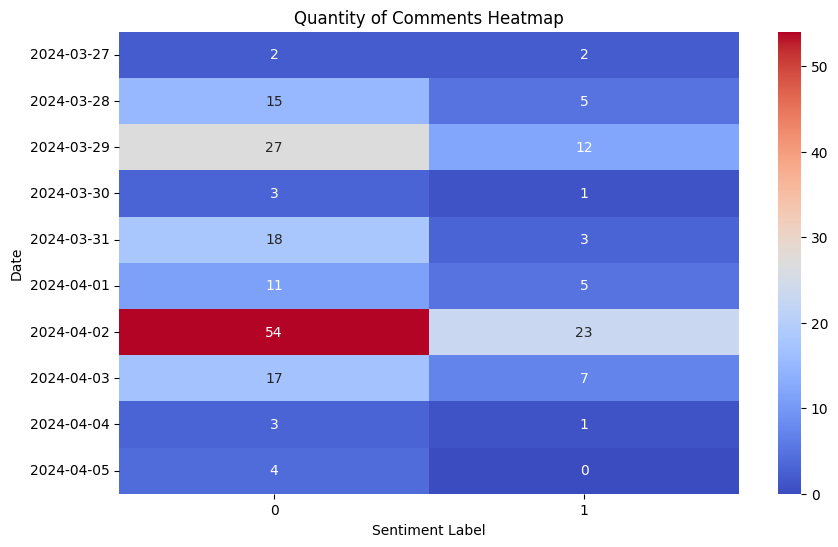

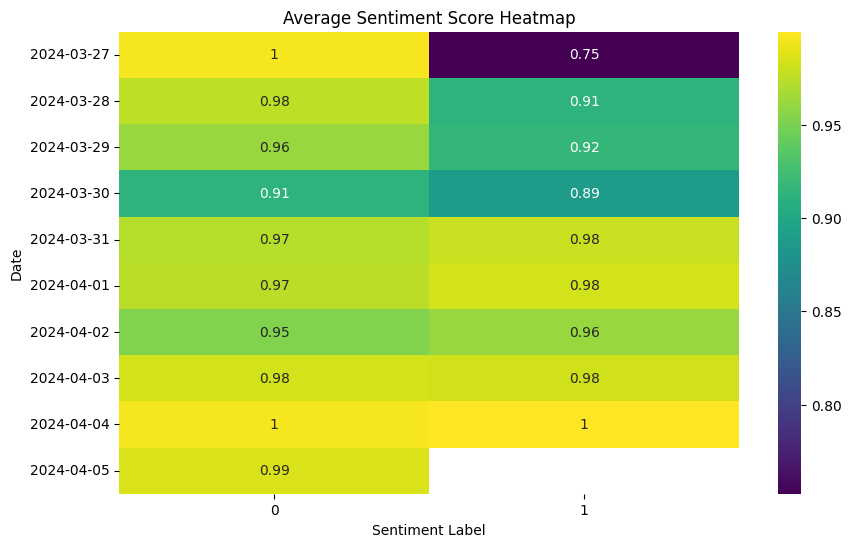

In [513]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace this with your sentiment_df)
data = {
    'date': sentiment_df['date'],
    'sentiment_label': sentiment_df['sentiment_label'],
    'sentiment_score': sentiment_df['sentiment_score']
}

visualization_df = pd.DataFrame(data)

# Heatmap 1: Quantity of Comments
# Counting comments
count_df = visualization_df.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)

# Plotting heatmap for quantity
plt.figure(figsize=(10, 6))
sns.heatmap(count_df, annot=True, cmap='coolwarm')
plt.title('Quantity of Comments Heatmap')
plt.xlabel('Sentiment Label')
plt.ylabel('Date')
plt.show()

# Heatmap 2: Average Sentiment Intensity
# Calculating average sentiment score
# Group by 'date' and 'sentiment_label' and compute average sentiment score
grouped = visualization_df.groupby(['date', 'sentiment_label']).mean().reset_index()

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='sentiment_score')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis')
plt.title('Average Sentiment Score Heatmap')
plt.xlabel('Sentiment Label')
plt.ylabel('Date')
plt.show()


### 3. Stacked Bar Chart with Sentiment Scores
- **What it shows**: Displays the number of comments broken down by sentiment score ranges, showing the strength of sentiments.
- **Interpretation**: Larger segments of stronger sentiments indicate more intense public feelings.
- **Insights**: Identifies the intensity of positive and negative sentiments on specific dates.

C:\Users\User\AppData\Local\Temp\ipykernel_21108\681731907.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



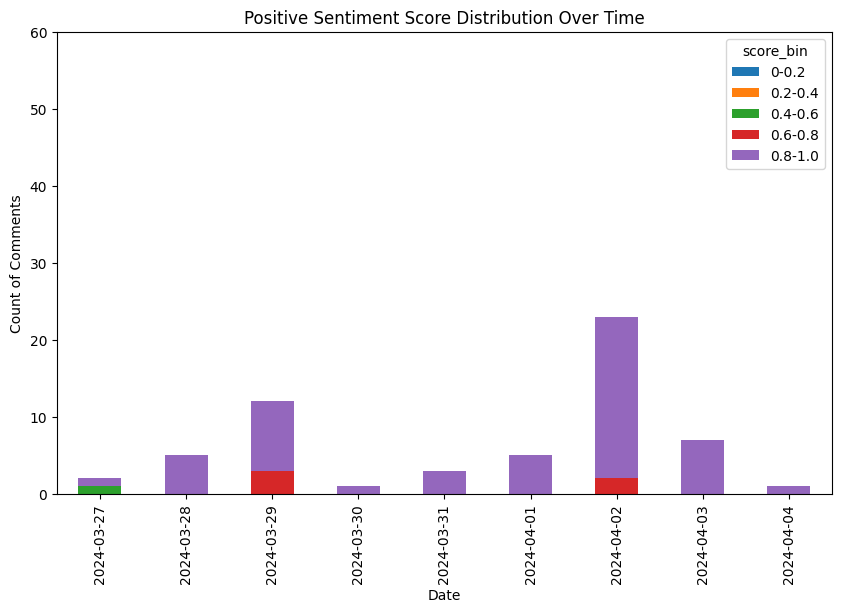

C:\Users\User\AppData\Local\Temp\ipykernel_21108\681731907.py:31: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



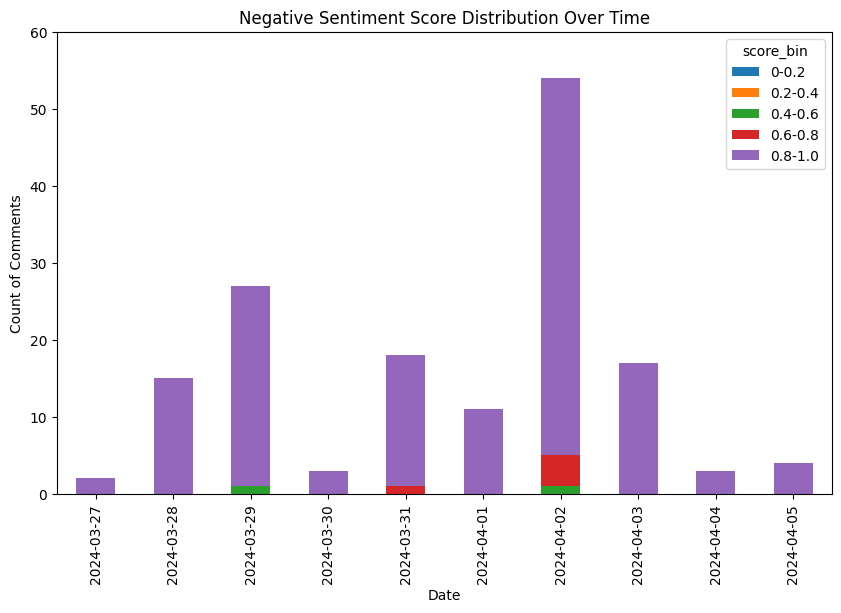

In [514]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your data)
data = {
    'date': sentiment_df['date'],
    'sentiment_score': sentiment_df['sentiment_score'],
    'sentiment_label': sentiment_df['sentiment_label']
}
visualization_df = pd.DataFrame(data)

# Bin the sentiment scores
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
visualization_df['score_bin'] = pd.cut(visualization_df['sentiment_score'], bins=bins, labels=labels)

# Separate Positive and Negative DataFrames
positive_df = visualization_df[visualization_df['sentiment_label'] == 1]
negative_df = visualization_df[visualization_df['sentiment_label'] == 0]

# Plotting Stacked Bar Chart for Positive Sentiments
pivot_positive = positive_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_positive.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Positive Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 60)
plt.show()

# Plotting Stacked Bar Chart for Negative Sentiments
pivot_negative = negative_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_negative.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Negative Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 60)
plt.show()


### 4. Cumulative Sentiment Score Over Time
- **What it shows**: A line graph displaying the cumulative sentiment score, accumulating sentiment intensities over time.
- **Interpretation**: A rising line indicates accumulating positive sentiment, and a falling line indicates increasing negative sentiment.
- **Insights**: 
    - Useful for understanding the overall trend in sentiment, whether it's becoming more positive or negative over time.
    - If the graph shows a big increase followed by a big decrease on a specific date, it suggests a significant shift in public sentiment, likely due to a specific event or news.

C:\Users\User\AppData\Local\Temp\ipykernel_21108\882369499.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



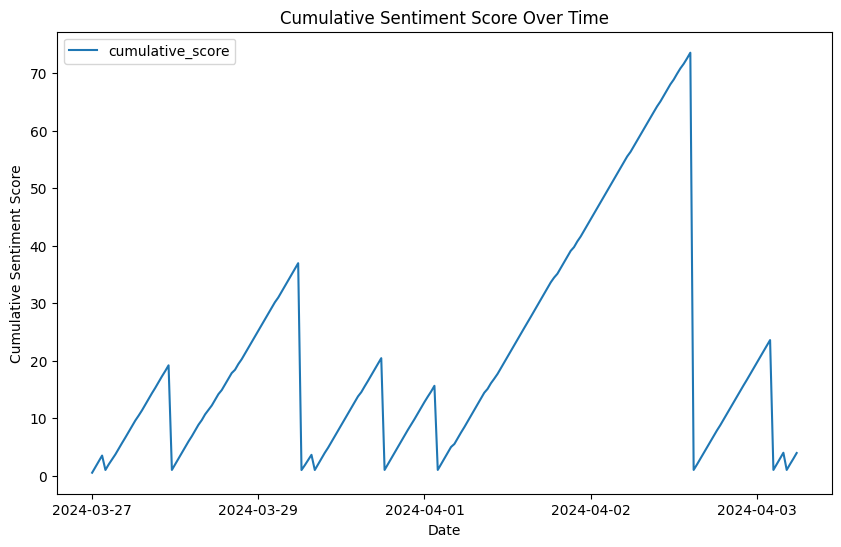

In [515]:
# Assuming 'sentiment_score' is a continuous value between 0 and 1
sentiment_df['cumulative_score'] = sentiment_df.groupby('date')['sentiment_score'].cumsum()

# Plot
sentiment_df.plot(x='date', y='cumulative_score', kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Cumulative Sentiment Score Over Time')
plt.show()


### 5. Scatter Plot
- **What it shows**: Each comment is plotted as a point, with its date and sentiment score.
- **Interpretation**: Clustering of points indicates many strong sentiments on specific dates.
- **Insights**: Pinpoints specific days with unusually strong sentiments, and the nature of these sentiments.

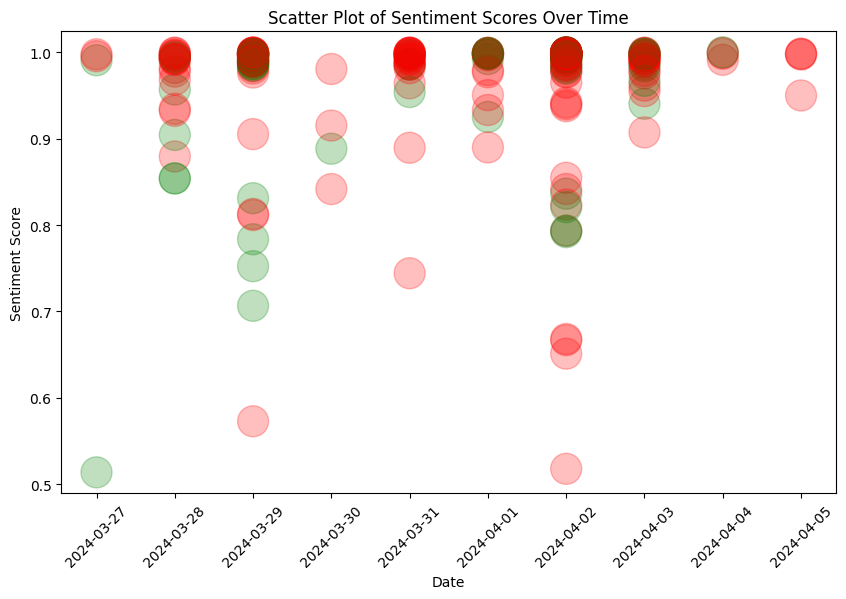

In [516]:
# Using different colors for different sentiment labels
colors = {0: 'red', 1: 'green'}

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(sentiment_df['date'], sentiment_df['sentiment_score'], c=sentiment_df['sentiment_label'].map(colors), s=500, alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Scatter Plot of Sentiment Scores Over Time')
plt.xticks(rotation=45)
plt.show()


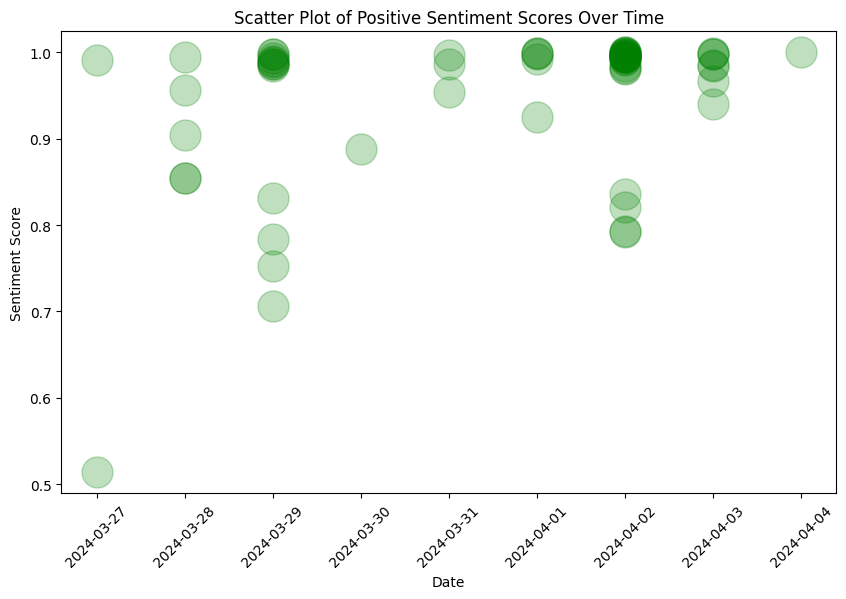

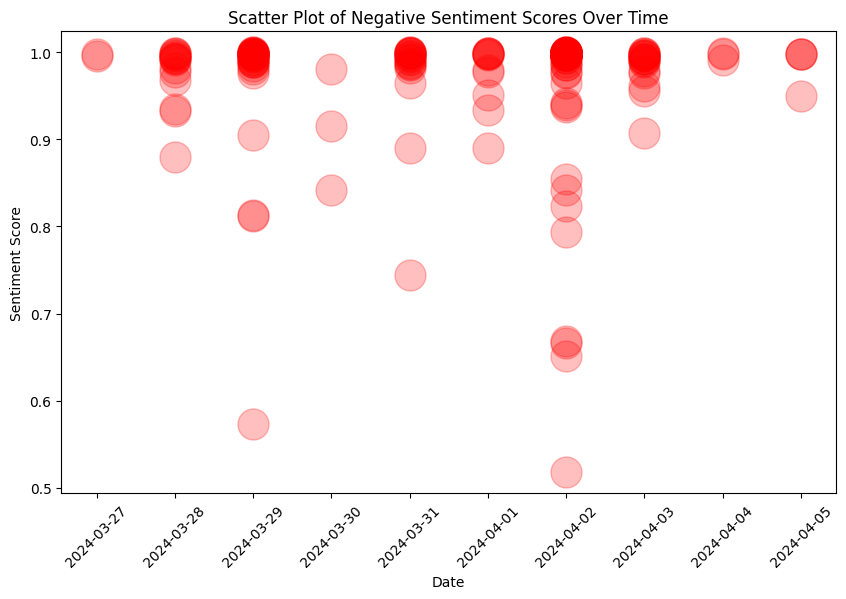

In [517]:
data = {
    'date': sentiment_df['date'],
    'sentiment_score': sentiment_df['sentiment_score'],
    'sentiment_label': sentiment_df['sentiment_label']
}
visualization_df = pd.DataFrame(data)

# Separating positive and negative comments
positive_df = visualization_df[visualization_df['sentiment_label'] == 1]
negative_df = visualization_df[visualization_df['sentiment_label'] == 0]

# Plot for Positive Comments
plt.figure(figsize=(10, 6))
plt.scatter(positive_df['date'], positive_df['sentiment_score'], color='green', s=500, alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Scatter Plot of Positive Sentiment Scores Over Time')
plt.xticks(rotation=45)
plt.show()

# Plot for Negative Comments
plt.figure(figsize=(10, 6))
plt.scatter(negative_df['date'], negative_df['sentiment_score'], color='red', s=500, alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Scatter Plot of Negative Sentiment Scores Over Time')
plt.xticks(rotation=45)
plt.show()



### 6. Box Plot and Violin Plot for Distribution of Sentiment Scores
- **What it shows**: These plots show the distribution and variability of sentiment scores for positive and negative comments.
- **Interpretation**: The spread and central tendency indicate how sentiment scores vary.
- **Insights**: Understands the consistency of sentiments and whether certain types (positive or negative) tend to have stronger feelings.

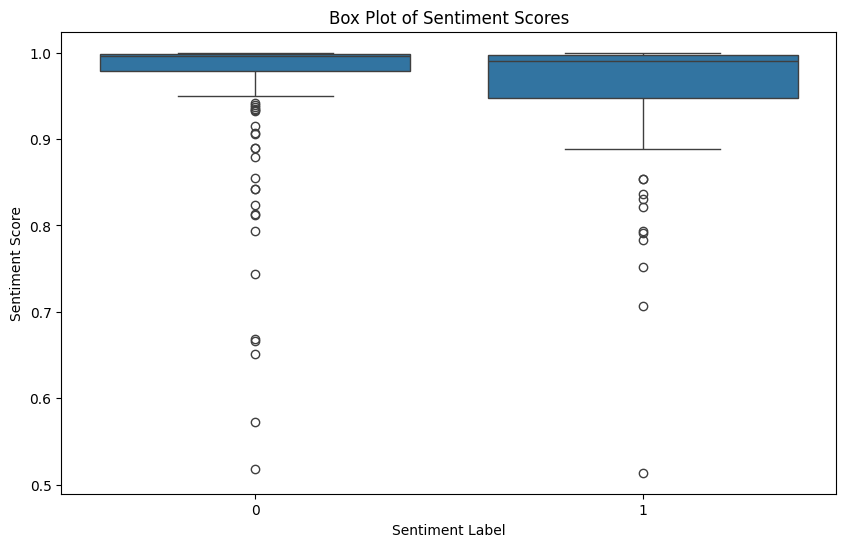

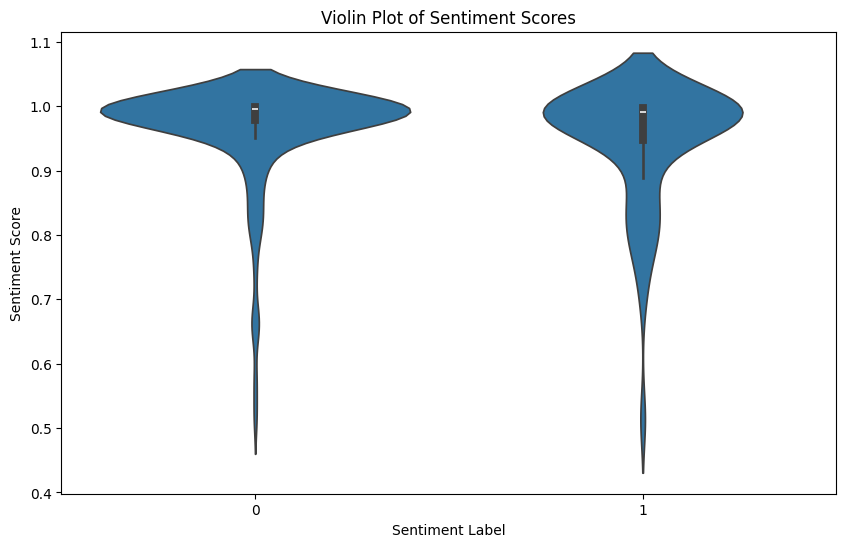

In [518]:
# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_label', y='sentiment_score', data=sentiment_df)
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.title('Box Plot of Sentiment Scores')
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='sentiment_label', y='sentiment_score', data=sentiment_df)
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.title('Violin Plot of Sentiment Scores')
plt.show()


## Analyzing the Overall Sentiment

### 1. Net Sentiment Score (NSS)

In [519]:
import pandas as pd

data = {
    'date': sentiment_df['date'],
    'sentiment_label': sentiment_df['sentiment_label'],
    'sentiment_score': sentiment_df['sentiment_score']
}
nss_df = pd.DataFrame(data)

# Calculate Net Sentiment Score
nss = nss_df.groupby('date').apply(
    lambda x: (x[x['sentiment_label'] == 1]['sentiment_score'].sum() 
               - x[x['sentiment_label'] == 0]['sentiment_score'].sum()))

# Convert to DataFrame and reset index
nss_df = nss.reset_index()
nss_df.columns = ['date', 'nss']  # Renaming columns

nss_df


C:\Users\User\AppData\Local\Temp\ipykernel_21108\1599906162.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,date,nss
0,2024-03-27,-0.488512
1,2024-03-28,-10.067503
2,2024-03-29,-14.959765
3,2024-03-30,-1.849094
4,2024-03-31,-14.566496
5,2024-04-01,-5.805468
6,2024-04-02,-29.311780
7,2024-04-03,-9.841775
8,2024-04-04,-1.988777
9,2024-04-05,-3.943588


### Normalizing Net Sentiment Scores to a Range of -1 to 0

In [520]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(-1, 0))
nss_df['normalized_nss'] = scaler.fit_transform(nss_df['nss'].values.reshape(-1, 1))

nss_df


,date,nss,normalized_nss
0,2024-03-27,-0.488512,-6.245005e-17
1,2024-03-28,-10.067503,-3.323354e-01
2,2024-03-29,-14.959765,-5.020684e-01
3,2024-03-30,-1.849094,-4.720430e-02
4,2024-03-31,-14.566496,-4.884243e-01
5,2024-04-01,-5.805468,-1.844675e-01
6,2024-04-02,-29.311780,-1.000000e+00
7,2024-04-03,-9.841775,-3.245039e-01
8,2024-04-04,-1.988777,-5.205051e-02
9,2024-04-05,-3.943588,-1.198711e-01


In [521]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400
1,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000
2,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000
3,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800
4,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200


In [522]:
voo_df['actual_label'] = (voo_df['Close'] > voo_df['Open']).astype(int)

voo_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,actual_label
0,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,1
1,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,0
2,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,0
3,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,1
4,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,1


In [523]:
nss_df['date'] = pd.to_datetime(nss_df['date'])
voo_df['Date'] = pd.to_datetime(voo_df['Date'])

voo_df['actual_label'] = voo_df['actual_label']

nss_df = pd.merge(nss_df, voo_df, how='left', left_on='date', right_on='Date')

nss_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

nss_df

,date,nss,normalized_nss,actual_label
0,2024-03-27,-0.488512,-6.245005e-17,1.0
1,2024-03-28,-10.067503,-3.323354e-01,0.0
2,2024-03-29,-14.959765,-5.020684e-01,NaN
3,2024-03-30,-1.849094,-4.720430e-02,NaN
4,2024-03-31,-14.566496,-4.884243e-01,NaN
5,2024-04-01,-5.805468,-1.844675e-01,0.0
6,2024-04-02,-29.311780,-1.000000e+00,1.0
7,2024-04-03,-9.841775,-3.245039e-01,1.0
8,2024-04-04,-1.988777,-5.205051e-02,0.0
9,2024-04-05,-3.943588,-1.198711e-01,NaN


1 means that stock price go higher, 0 means that stock price go lower, NaN means non-trading days.

### Correlation Analysis and Statistical Measures

In [524]:
# Calculate correlation for NSS
correlation_nss = nss_df['normalized_nss'].corr(nss_df['actual_label'], method='pearson')
print("Pearson Correlation Coefficient (NSS):", correlation_nss)

Pearson Correlation Coefficient (NSS): -0.3811694293596272


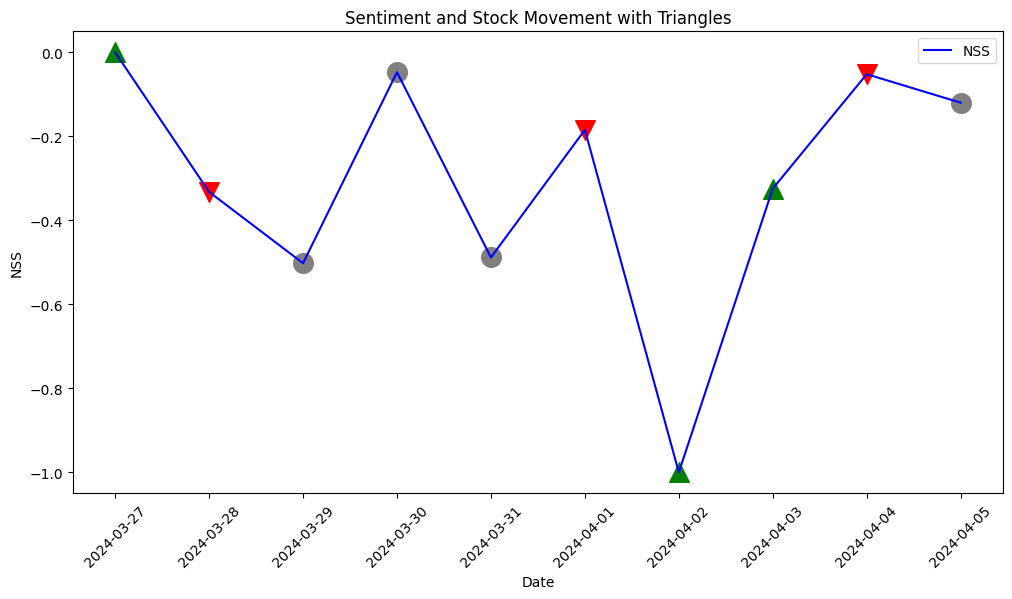

In [525]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(nss_df['date'], nss_df['normalized_nss'], label='NSS', color='blue')

for i, row in nss_df.iterrows():
    if row['actual_label'] == 1:
        plt.scatter(row['date'], row['normalized_nss'], color='green', marker='^', s=200)
    elif row['actual_label'] == 0:
        plt.scatter(row['date'], row['normalized_nss'], color='red', marker='v', s=200)
    else:
        plt.scatter(row['date'], row['normalized_nss'], color='grey', marker='o', s=200)

plt.xlabel('Date')
plt.ylabel('NSS')
plt.title('Sentiment and Stock Movement with Triangles')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [526]:
import plotly.graph_objects as go

# Creating the line plot for weighted average sentiment
fig = go.Figure()
fig.add_trace(go.Scatter(x=nss_df['date'], y=nss_df['normalized_nss'], mode='lines', name='NSS Sentiment', line=dict(color='blue')))

# Adding markers for actual stock labels
for i, row in nss_df.iterrows():
    if row['actual_label'] == 1:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['normalized_nss']], mode='markers', marker_symbol='triangle-up', marker_color='green', marker_size=10, name='Stock Up'))
    elif row['actual_label'] == 0:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['normalized_nss']], mode='markers', marker_symbol='triangle-down', marker_color='red', marker_size=10, name='Stock Down'))
    else:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['normalized_nss']], mode='markers', marker_symbol='circle', marker_color='grey', marker_size=10, name='Market Closed'))

# Setting layout for the figure
fig.update_layout(title='Sentiment and Stock Movement with Interactive Triangles', xaxis_title='Date', yaxis_title='NSS Sentiment', legend_title='Legend')
fig.show()

### Correlation between Stock Daily Return and NSS Sentiment

In [527]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df['daily_return'] = (voo_df['Close'] - voo_df['Open']) / voo_df['Open']

voo_df

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,0.002607
1,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,-0.000353
2,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,-0.002846
3,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,0.001260
4,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,0.003194
5,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6858400,-0.020200


In [528]:
voo_df['Date'] = pd.to_datetime(voo_df['Date'])
nss_df['date'] = pd.to_datetime(nss_df['date'])

nss_df = pd.merge(nss_df, voo_df, how='left', left_on='date', right_on='Date')
nss_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

nss_df

,date,nss,normalized_nss,actual_label,daily_return
0,2024-03-27,-0.488512,-6.245005e-17,1.0,0.002607
1,2024-03-28,-10.067503,-3.323354e-01,0.0,-0.000353
2,2024-03-29,-14.959765,-5.020684e-01,NaN,NaN
3,2024-03-30,-1.849094,-4.720430e-02,NaN,NaN
4,2024-03-31,-14.566496,-4.884243e-01,NaN,NaN
5,2024-04-01,-5.805468,-1.844675e-01,0.0,-0.002846
6,2024-04-02,-29.311780,-1.000000e+00,1.0,0.001260
7,2024-04-03,-9.841775,-3.245039e-01,1.0,0.003194
8,2024-04-04,-1.988777,-5.205051e-02,0.0,-0.020200
9,2024-04-05,-3.943588,-1.198711e-01,NaN,NaN


#### Dual Y-Axis Time-Series Plot for Normalized NSS and Daily Stock Returns

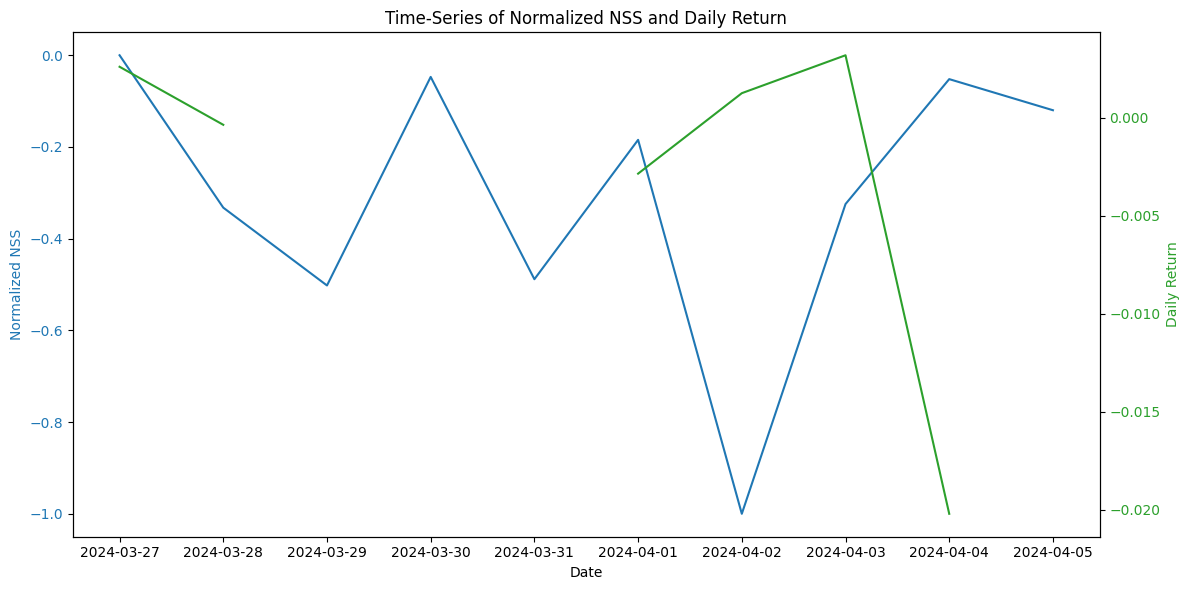

In [529]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis (ax1) for NSS
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized NSS', color=color)
ax1.plot(nss_df['date'], nss_df['normalized_nss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) for Daily Return
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Daily Return', color=color)
ax2.plot(nss_df['date'], nss_df['daily_return'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show plot
plt.title('Time-Series of Normalized NSS and Daily Return')
fig.tight_layout()  # otherwise the right y-label may be slightly clipped
plt.show()


### 2. Weighted Average Calculation

In [530]:
import pandas as pd

data = {
    'date': sentiment_df['date'],
    'sentiment_label': sentiment_df['sentiment_label'],
    'sentiment_score': sentiment_df['sentiment_score']
}
weighted_avg_df = pd.DataFrame(data)

# Calculate Weighted Average Sentiment
weighted_avg = weighted_avg_df.groupby('date').apply(
    lambda x: (x['sentiment_label'] * x['sentiment_score']).sum() / x['sentiment_score'].sum())

# Convert to DataFrame and reset index
weighted_avg_df = weighted_avg.reset_index()
weighted_avg_df.columns = ['date', 'weighted_average']  # Renaming columns

weighted_avg_df


C:\Users\User\AppData\Local\Temp\ipykernel_21108\580712688.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,date,weighted_average
0,2024-03-27,0.430163
1,2024-03-28,0.237741
2,2024-03-29,0.297607
3,2024-03-30,0.244999
4,2024-03-31,0.143669
5,2024-04-01,0.314310
6,2024-04-02,0.300776
7,2024-04-03,0.291346
8,2024-04-04,0.250683
9,2024-04-05,0.000000


In [531]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400
1,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000
2,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000
3,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800
4,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200
5,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6858400


In [532]:
voo_df['actual_label'] = (voo_df['Close'] > voo_df['Open']).astype(int)

voo_df

,Date,Open,High,Low,Close,Adj Close,Volume,actual_label
0,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,1
1,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,0
2,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,0
3,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,1
4,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,1
5,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6858400,0


In [533]:
weighted_avg_df['date'] = pd.to_datetime(weighted_avg_df['date'])
voo_df['Date'] = pd.to_datetime(voo_df['Date'])

weighted_avg_df = pd.merge(weighted_avg_df, voo_df, how='left', left_on='date', right_on='Date')

weighted_avg_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

weighted_avg_df

,date,weighted_average,actual_label
0,2024-03-27,0.430163,1.0
1,2024-03-28,0.237741,0.0
2,2024-03-29,0.297607,NaN
3,2024-03-30,0.244999,NaN
4,2024-03-31,0.143669,NaN
5,2024-04-01,0.314310,0.0
6,2024-04-02,0.300776,1.0
7,2024-04-03,0.291346,1.0
8,2024-04-04,0.250683,0.0
9,2024-04-05,0.000000,NaN


1 means that stock price go higher, 0 means that stock price go lower, NaN means non-trading days.

### Correlation Analysis and Statistical Measures

In [534]:
import pandas as pd

correlation = weighted_avg_df['weighted_average'].corr(weighted_avg_df['actual_label'], method='pearson')
print("Pearson Correlation Coefficient:", correlation)

Pearson Correlation Coefficient: 0.5856065505995152


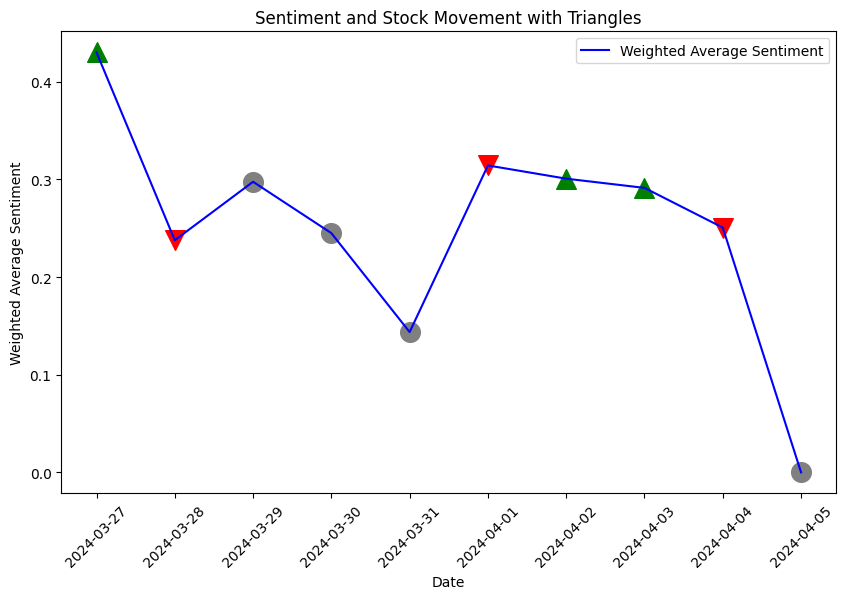

In [535]:
plt.figure(figsize=(10, 6))
plt.plot(weighted_avg_df['date'], weighted_avg_df['weighted_average'], label='Weighted Average Sentiment', color='blue')

for i, row in weighted_avg_df.iterrows():
    if row['actual_label'] == 1:
        plt.scatter(row['date'], row['weighted_average'], color='green', marker='^', s=200)
    elif row['actual_label'] == 0:
        plt.scatter(row['date'], row['weighted_average'], color='red', marker='v', s=200)
    else:
        plt.scatter(row['date'], row['weighted_average'], color='grey', marker='o', s=200)

plt.xlabel('Date')
plt.ylabel('Weighted Average Sentiment')
plt.title('Sentiment and Stock Movement with Triangles')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [536]:
import plotly.graph_objects as go

# Creating the line plot for weighted average sentiment
fig = go.Figure()
fig.add_trace(go.Scatter(x=weighted_avg_df['date'], y=weighted_avg_df['weighted_average'], mode='lines', name='Weighted Average Sentiment', line=dict(color='blue')))

# Adding markers for actual stock labels
for i, row in weighted_avg_df.iterrows():
    if row['actual_label'] == 1:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['weighted_average']], mode='markers', marker_symbol='triangle-up', marker_color='green', marker_size=10, name='Stock Up'))
    elif row['actual_label'] == 0:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['weighted_average']], mode='markers', marker_symbol='triangle-down', marker_color='red', marker_size=10, name='Stock Down'))
    else:
        fig.add_trace(go.Scatter(x=[row['date']], y=[row['weighted_average']], mode='markers', marker_symbol='circle', marker_color='grey', marker_size=10, name='Market Closed'))

# Setting layout for the figure
fig.update_layout(title='Sentiment and Stock Movement with Interactive Triangles', xaxis_title='Date', yaxis_title='Weighted Average Sentiment', legend_title='Legend')
fig.show()


### Correlation between Stock Daily Returns and Weighted Average Sentiment

In [537]:
voo_df = pd.read_csv('../datasets/VOO_sentiment.csv')
voo_df['daily_return'] = (voo_df['Close'] - voo_df['Open']) / voo_df['Open']

voo_df

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2024-03-27,479.510010,480.869995,477.450012,480.760010,480.760010,4951400,0.002607
1,2024-03-28,480.869995,482.160004,480.500000,480.700012,480.700012,4065000,-0.000353
2,2024-04-01,481.440002,481.959991,478.829987,480.070007,480.070007,5734000,-0.002846
3,2024-04-02,476.329987,476.989990,474.709991,476.929993,476.929993,4817800,0.001260
4,2024-04-03,475.839996,478.799988,475.790009,477.359985,477.359985,6218200,0.003194
5,2024-04-04,481.200012,481.480011,471.269989,471.480011,471.480011,6858400,-0.020200


In [538]:
voo_df['Date'] = pd.to_datetime(voo_df['Date'])
weighted_avg_df['date'] = pd.to_datetime(weighted_avg_df['date'])

weighted_avg_df = pd.merge(weighted_avg_df, voo_df, how='left', left_on='date', right_on='Date')
weighted_avg_df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

weighted_avg_df

,date,weighted_average,actual_label,daily_return
0,2024-03-27,0.430163,1.0,0.002607
1,2024-03-28,0.237741,0.0,-0.000353
2,2024-03-29,0.297607,NaN,NaN
3,2024-03-30,0.244999,NaN,NaN
4,2024-03-31,0.143669,NaN,NaN
5,2024-04-01,0.314310,0.0,-0.002846
6,2024-04-02,0.300776,1.0,0.001260
7,2024-04-03,0.291346,1.0,0.003194
8,2024-04-04,0.250683,0.0,-0.020200
9,2024-04-05,0.000000,NaN,NaN


#### Dual Y-Axis Time-Series Plot for Weighted Average and Daily Stock Returns

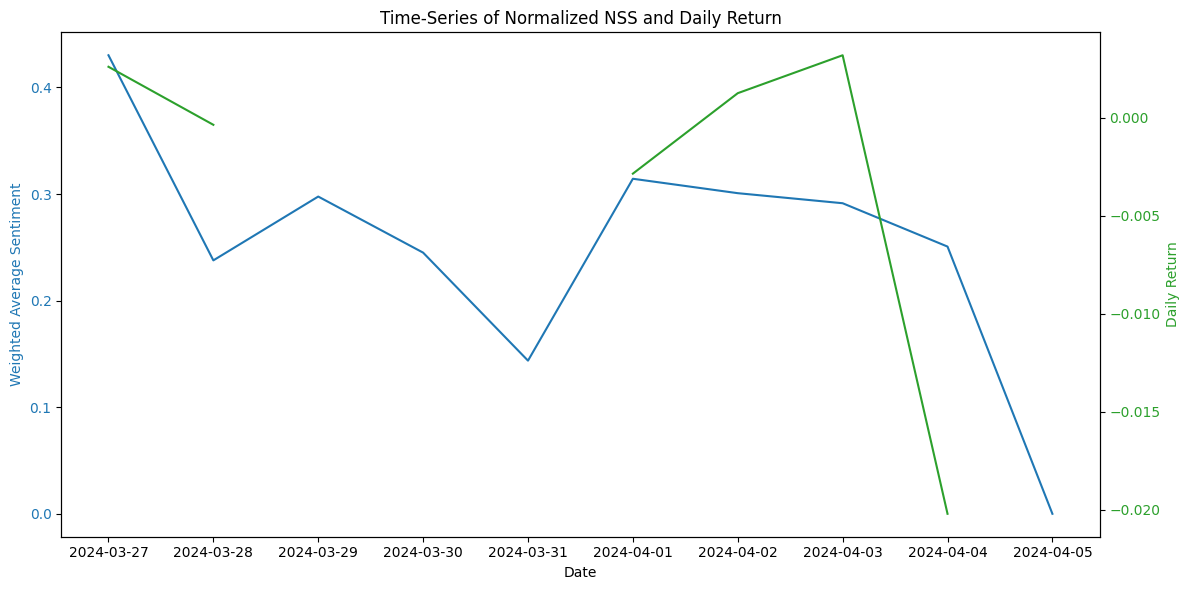

In [539]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis (ax1) for NSS
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Sentiment', color=color)
ax1.plot(nss_df['date'], weighted_avg_df['weighted_average'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) for Daily Return
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Daily Return', color=color)
ax2.plot(nss_df['date'], weighted_avg_df['daily_return'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and show plot
plt.title('Time-Series of Normalized NSS and Daily Return')
fig.tight_layout()  # otherwise the right y-label may be slightly clipped
plt.show()
